## Trying to get some sort of automated analysis

In [ ]:
# !pip install suite2p
# !pip install scanimage-tiff-reader
# !pip install -U scikit-image
# !pip install tiffile

### Load tiff file

In [1]:
cd '/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/ChAT_gCaMP6s_example2/'

/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/ChAT_gCaMP6s_example2


In [131]:
from ScanImageTiffReader import ScanImageTiffReader as sitr
from tifffile import TiffFile, imwrite, xml2dict
import numpy as np
import os
from skimage.viewer import ImageViewer
import skimage
import matplotlib.pyplot as plt
from suite2p import register

Sould define a tif object:
* load tif only once
* im just call tif.data()

In [168]:
class tiffStack:
    """Loader for tiff stack obtained from 2P rig using SciScan into Python"""
    def __init__(self, filepath, filename):
        ### directories and paths ###
        self.basedir = '/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/'
        self.filepath = filepath + '/'
        self.filename = filename 
        self.savename = 'rg_' + filename 
        self.savepath = self.basedir + self.filepath + "analysis/"
        self.loadpath = self.basedir + self.filepath + self.filename + ".tif"
        self.reg_file = self.savepath + self.savename + '.tif'
        ### Load tif file
        self.tif = sitr(self.loadpath)
        ### Run default methods
        self.metadata = self.pull_metadata()
    
    def pull_metadata(self):
        imgDescription = self.getImageDescription()
        metadata = {
            'Lt' : imgDescription['OME']['Image']['Pixels']['SizeT'],
            'Lx' : imgDescription['OME']['Image']['Pixels']['SizeX'],
            'Ly' : imgDescription['OME']['Image']['Pixels']['SizeY'],
            'nChannels' :  imgDescription['OME']['Image']['Pixels']['SizeC'],
            'realX' : np.multiply(imgDescription['OME']['StructuredAnnotations']['XMLAnnotation'][3]['Value']['ImagePhysicalDimensions']['PhysicalSizeX'],1e6), # in um
            'realY' : np.multiply(imgDescription['OME']['StructuredAnnotations']['XMLAnnotation'][3]['Value']['ImagePhysicalDimensions']['PhysicalSizeY'],1e6), # in um
            'realT' : imgDescription['OME']['StructuredAnnotations']['XMLAnnotation'][3]['Value']['ImagePhysicalDimensions']['PhysicalSizeT'], # in s
            'samplingRate' : 0,
        }
        metadata['samplingRate'] = np.divide(metadata['Lt'],metadata['realT'])
        return metadata
    
    def getImageDescription(self):
        from tiffile import xml2dict
        imgDescription = xml2dict(self.tif.description(0))
        return imgDescription
    
    def getData(self):
        img = self.tif.data();
        return img
    
    def rescale(self):
        # rescaling SciScan images from 11 bits to 16 bits
        rsData = self.getData();
        rsData[rsData<np.power(2,15)] = np.power(2,15) # remove spurious negative values
        rsData = rsData - np.power(2,15) # subtract baseline
        rsData = rsData * 32 # multiply by 2^16 - 2^11
        return rsData
    
    def saveNew(self):
        if not os.path.exists(self.savepath):
            os.mkdir(self.savepath)
        rsData = self.rescale();
        skimage.external.tifffile.imsave(self.reg_file, rsData, compress=0, description=self.tif.description(0))
    
    def histRescaled(self):
        rsData = self.rescale();
        self.plotHistogram(rsData);
    
    def histRescaled_single(self,t=0):
        rsData = self.rescale();
        if t>=0 & t<np.shape(rsData)[0]:
            rsData = rsData[t,:,:];
        else:
            t=0
            print('Showing first plane; t is out-of-bounds')
        self.plotHistogram(rsData);
    
    def s2p_rgOps(self):
        ops = {
            'reg_file': self.reg_file,
            'Ly': ts.metadata['Ly'],
            'Lx': ts.metadata['Lx'],
            'nchannels' : 1, # each tiff has these many channels per plane
            'align_by_chan' : 1, # when multi-channel, you can align by non-functional channel (1-based)
            'batch_size': 200, # number of frames per batch
            'maxregshift': 0.1, # max allowed registration shift, as a fraction of frame max(width and height)
            'nimg_init': 200,
            'subpixel' : 10, # precision of subpixel registration (1/subpixel steps)
            'smooth_sigma': 1.0, # ~1 good for 2P recordings, recommend >5 for 1P recordings
            'th_badframes': 1.0, # this parameter determines which frames to exclude when determining cropping - set it smaller to exclude more frames
            'pad_fft': False,
            'do_phasecorr': True,
            'nonrigid': False,
            'num_workers': 0, # 0 to select num_cores, -1 to disable parallelism, N to enforce value
            'non-rigid': False,
        }
        return ops

    
    @staticmethod 
    def plotHistogram(rsData):
        if np.ndim(rsData)==2:
            imgData = rsData
        elif np.ndim(rsData)==3:
            imgData = np.mean(rsData,axis=0)
        # [hist, bin_edges] = np.histogram(rsData[rsData>0], bins='fd', density=True) #ignore black pixels
        # bins = (bin_edges[:-1] + bin_edges[1:]) / 2
        [hist, bins] = skimage.exposure.histogram(rsData[rsData>0], normalize=True) #ignore black pixels
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 9), gridspec_kw={'width_ratios': [1, .1, 1]})

        plt.sca(ax0);
        plt.imshow(imgData, cmap=plt.cm.gray, interpolation='nearest')
        plt.xticks([]); plt.yticks([]); plt.colorbar();
        
        plt.sca(ax1);
        plt.plot([0,0], [0,np.size(rsData[rsData==0])/np.size(rsData)], lw=2)
        plt.xticks([0])
        ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)
        
        plt.sca(ax2);
        plt.plot(bins, hist, lw=2)
        ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)
        return fig, ax0, ax1, ax2

In [169]:
fpath = 'ChAT_gCaMP6s_example2';
fname = '20190520_L03_04Bars_Original';
ts = tiffStack(fpath,fname);
ops = ts.s2p_rgOps()
refImg = register.pick_init(ops)


In [176]:
maskMul,maskOffset,cfRefImg = register.prepare_masks(refImg,ops)
refAndMasks = [maskMul,maskOffset,cfRefImg]
aligned_data, yshift, xshift, corrXY, yxnr = register.phasecorr(ts.rescale(), refAndMasks, ops)

In [191]:
# np.shape(yxnr)
# type(aligned_data[0,0,0])
# ts.plotHistogram(aligned_data[0]);
# ts.plotHistogram(refImg);

# skimage.io.imsave('refImgTest.tif',refImg)
skimage.external.tifffile.imsave('refImgTest.tif', np.ndarray.astype(refImg,'uint16'), compress=0)

In [120]:
fpath = 'ChAT_gCaMP6s_example2';
fname = '20190520_L03_04Bars_Original';

# fpath = '20190502_ChATgCaMP6s_6dpf_partial';
# fname = 'testOriginal';
ts = tiffStack(fpath,fname);
# np.shape(ts.rescale())
ts.saveNew()
# ts.histRescaled();
# ts.histRescaled_single(t=500);
# plt.savefig("{0}.svg".format("CalciumTransients"), transparent=True, format="svg")

In [216]:
# test_ops =  np.load('./analysis/suite2p/ops1.npy')
test_ops =  np.load('./analysis/suite2p/plane0/ops.npy')
test_ops = test_ops.item()

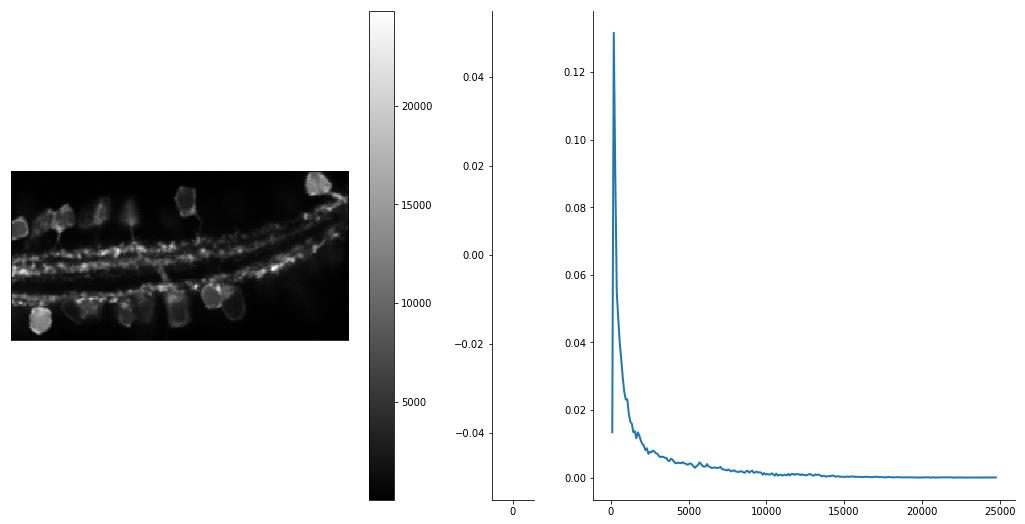

In [217]:

ts.plotHistogram(test_ops['refImg']);



### Run with code

> Notes:

> Would be great to extract things from tiff files beforehand including:

> fs (sampling rate)

> length (to inform nimg_init)

> number of channels 

SciScan Tiff Reader does not support compressed data. Make sure to save as uncompressed OME-TIFF from ImageJ/FIJI

In [ ]:
import numpy as np
import sys
import suite2p
from suite2p.run_s2p import run_s2p

# set your options for running
# overwrites the run_s2p.default_ops
ops = {
        'fast_disk': [], # used to store temporary binary file, defaults to save_path0 (set as a string NOT a list)
        'save_path0': [], # stores results, defaults to first item in data_path
        'delete_bin': False, # whether to delete binary file after processing
        # main settings
        'nplanes' : 1, # each tiff has these many planes in sequence
        'nchannels' : 1, # each tiff has these many channels per plane
        'functional_chan' : 1, # this channel is used to extract functional ROIs (1-based)
        'diameter':4.5, # this is the main parameter for cell detection, 2-dimensional if Y and X are different (e.g. [6 12])
        'tau':  2.0, # this is the main parameter for deconvolution (GCaMP6f = 0.7; GCaMP6m = 1.25; GCaMP6s = 2.0)
        'fs': 6.1,  # sampling rate (total across planes) (128 x 128 = 12.2; 256 x 128 = 6.1)
        # output settings
        'save_mat': False, # whether to save output as matlab files
        'combined': True, # combine multiple planes into a single result /single canvas for GUI
        # parallel settings
        'num_workers': 0, # 0 to select num_cores, -1 to disable parallelism, N to enforce value
        'num_workers_roi': -1, # 0 to select number of planes, -1 to disable parallelism, N to enforce value
        # registration settings
        'do_registration': True, # whether to register data
        'nimg_init': 200, # subsampled frames for finding reference image
        'batch_size': 200, # number of frames per batch
        'maxregshift': 0.1, # max allowed registration shift, as a fraction of frame max(width and height)
        'align_by_chan' : 1, # when multi-channel, you can align by non-functional channel (1-based)
        'reg_tif': True, # whether to save registered tiffs
        'subpixel' : 10, # precision of subpixel registration (1/subpixel steps)
        'nonrigid': False, # wheter to perform non-rigid registration
        # cell detection settings
        'connected': False, # whether or not to keep ROIs fully connected (set to 0 for dendrites)
        'navg_frames_svd': 5000, # max number of binned frames for the SVD
        'nsvd_for_roi': 1000, # max number of SVD components to keep for ROI detection
        'max_iterations': 20, # maximum number of iterations to do cell detection
        'ratio_neuropil': 6., # ratio between neuropil basis size and cell radius
        'ratio_neuropil_to_cell': 3, # minimum ratio between neuropil radius and cell radius
        'tile_factor': 1., # use finer (>1) or coarser (<1) tiles for neuropil estimation during cell detection
        'threshold_scaling': 1., # adjust the automatically determined threshold by this scalar multiplier
        'max_overlap': 0.75, # cells with more overlap than this get removed during triage, before refinement
        'inner_neuropil_radius': 2, # number of pixels to keep between ROI and neuropil donut
        'outer_neuropil_radius': np.inf, # maximum neuropil radius
        'min_neuropil_pixels': 350, # minimum number of pixels in the neuropil
        # deconvolution settings
        'baseline': 'maximin', # baselining mode
        'win_baseline': 60., # window for maximin
        'sig_baseline': 10., # smoothing constant for gaussian filter
        'prctile_baseline': 8.,# optional (whether to use a percentile baseline)
        'neucoeff': .7,  # neuropil coefficient
      }

In [ ]:
# provide an h5 path in 'h5py' or a tiff path in 'data_path'
# db overwrites any ops (allows for experiment specific settings)
db = {
      'h5py': [], # a single h5 file path
      'h5py_key': 'data',
      'look_one_level_down': False, # whether to look in ALL subfolders when searching for tiffs
#       'data_path': ['/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/20190502_ChATgCaMP6s_6dpf_partial/test'], # a list of folders with tiffs 
      'data_path': ['/Users/angueyraaristjm/Documents/LiImaging/TwoPhoton/ChAT_gCaMP6s_example2'], # a list of folders with tiffs 
                                             # (or folder of folders with tiffs if look_one_level_down is True, or subfolders is not empty)
                                            
      'subfolders': [], # choose subfolders of 'data_path' to look in (optional)
      'fast_disk': [], # string which specifies where the binary file will be stored (should be an SSD)
    }

# run one experiment
opsEnd=run_s2p(ops=ops,db=db)

In [ ]:
# make a list of db's and loop over them
db = []
db.append({'data_path': ['C:/Users/carse/github/tiffs']})
db.append({'data_path': ['C:/Users/carse/github/tiffs2']})

for dbi in db:
    opsEnd=run_s2p(ops=ops,db=dbi)

In [ ]:
# only run on specified tiffs
db = {
      'h5py': [], # a single h5 file path
      'h5py_key': 'data',
      'look_one_level_down': False, # whether to look in ALL subfolders when searching for tiffs
      'data_path': ['C:/Users/carse/github/tiffs/'], 
                            # a list of folders with tiffs 
                            # (or folder of folders with tiffs if look_one_level_down is True, or subfolders is not empty)
                            
      'subfolders': [], # choose subfolders of 'data_path' to look in (optional)
      'fast_disk': 'C:/BIN', # string which specifies where the binary file will be stored (should be an SSD)
      'tiff_list': ['file022.tif', 'file023.tif'] # list of tiffs in folder * data_path *!
    }


# run one experiment
opsEnd=run_s2p(ops=ops,db=db)

### Use BeautifulSoup to parse tiff ImageDescription

In [ ]:
from bs4 import BeautifulSoup as bs
metadata = bs(tif.description(0),'xml')
Lt = float(metadata.Pixels.get_attribute_list('SizeT')[0])
Lx = float(metadata.Pixels.get_attribute_list('SizeX')[0])
Ly = float(metadata.Pixels.get_attribute_list('SizeY')[0])
nChannels = float(metadata.Pixels.get_attribute_list('SizeC')[0])
realX = np.multiply(float(metadata.ImagePhysicalDimensions.get_attribute_list('PhysicalSizeX')[0]),1e6)
realXUnit = 'um'
realY = np.multiply(float(metadata.ImagePhysicalDimensions.get_attribute_list('PhysicalSizeY')[0]),1e6)
realYUnit = 'um'
realT = float(metadata.ImagePhysicalDimensions.get_attribute_list('PhysicalSizeT')[0])
realXUnit = 's'
samplingRate = np.divide(Lt,realT)
# print (bs.prettify(metadata))